## Loading the MNIST dataset

In [2]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

# The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard 
# deviation of the MNIST dataset. This is equivalent to scaling all pixel values between [0, 1].
transform = torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(
                (0.1307,), (0.3081,))
            ])

train_data = torchvision.datasets.MNIST('', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('', train=False, download=True, transform=transform)

# We can see some information about this data, including the transform we've applied.
# train_data
# test_data

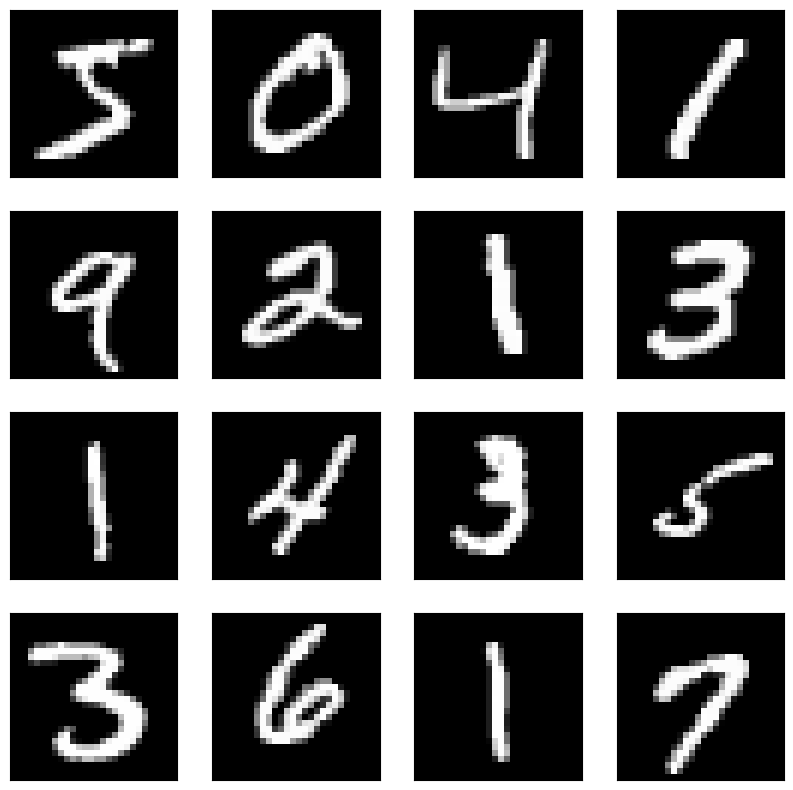

In [3]:
# Visualize the first 16 elements of the training set
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(train_data.data[i], cmap='gray')


## Convolutional Neural Network

In [4]:
nn = torch.nn

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 28, kernel_size=5, stride=1, padding=2)
        self.conv1.weight.data.normal_(0, 0.0025)  
        self.conv1.bias.data.fill_(0.1) 
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(28, 16, kernel_size=5, stride=1)
        self.conv2.weight.data.normal_(0, 0.0025)
        self.conv2.bias.data.fill_(0.1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # First dense layer
        self.fc1_units = 1024  
        self.fc1 = nn.Linear(16 * 5 * 5, self.fc1_units)
        self.relu3 = nn.ReLU()
        
        # Second dense layer
        self.fc2_units = 128  
        self.fc2 = nn.Linear(self.fc1_units, self.fc2_units)
        self.relu4 = nn.ReLU()
        
        self.dropout_rate = 0.2
        self.dropout = nn.Dropout(p=self.dropout_rate)
        
        # Output dense layer
        self.fc3_units = 10  
        self.fc3 = nn.Linear(self.fc2_units, self.fc3_units)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.dropout(x)
        x = self.logsoftmax(self.fc3(x))
        return x

model = CNN()

print(model)


CNN(
  (conv1): Conv2d(1, 28, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=1024, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [5]:
# your code here
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             728
              ReLU-2           [-1, 28, 28, 28]               0
         MaxPool2d-3           [-1, 28, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]          11,216
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                 [-1, 1024]         410,624
              ReLU-9                 [-1, 1024]               0
           Linear-10                  [-1, 128]         131,200
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
       LogSoftmax-14                   

## Loss function, accuracy and train/test algorithm

In [6]:
# PyTorch requires that we specify a device. This is the CPU or GPU that PyTorch will use to run the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# declare loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)


# Split train into train2 and val
percent_train2 = 0.9
percent_val = 0.1

size_train2 = int(len(train_data) * percent_train2)
size_val = len(train_data) - size_train2

train_data2, val_data = torch.utils.data.random_split(train_data, [size_train2, size_val])
print(f'train_data2 size: {len(train_data2)}')
print(f'val_data size: {len(val_data)}\n')


# load train2 and val data
train_data2_loader = torch.utils.data.DataLoader(train_data2, batch_size=100)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size= len(val_data))

# function to extract features and labels from a data loader
def extract_features_and_labels(data_loader):
    all_features = []
    all_labels = []
    for features, labels in data_loader:
        all_features.append(features)
        all_labels.append(labels)

        # combine labels into a tensor
        feature_tensor = torch.cat(all_features)
        label_tensor = torch.cat(all_labels)
    
    return  feature_tensor, label_tensor

# accuracy calculator
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# function to predict and classify
def predict(model, data):
    with torch.no_grad():
        # Set the model to evaluation mode
#         model.eval()
        
        # output probabilities
        outputs = model.forward(data)
        
        # output classifications
        predicted_classes = torch.argmax(outputs, dim=1)
        
    return predicted_classes

# function to train model
def train(num_epochs, model, train_data_loader, val_data_loader, optimizer, loss_function):
    batch_count = 0
    
    # extract feature tensors for train data and val data
    train_features = extract_features_and_labels(train_data_loader)[0]
    train_labels = extract_features_and_labels(train_data_loader)[1]
    
    val_features = extract_features_and_labels(val_data_loader)[0]
    val_labels = extract_features_and_labels(val_data_loader)[1]
    
     
    for epoch in range(1, num_epochs+1):
        for inputs, labels in train_data_loader:
            batch_count += 1

            # clear gradients for this training step
            optimizer.zero_grad()
            # make predictions
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # compute gradients
            loss.backward()
            # update gradients
            optimizer.step()
            
            if batch_count%100 == 0:
                print(f'batch {batch_count}, loss: {loss:.4f}')
        
        # predict train2 and val
        train_pred = predict(model, train_features)
        val_pred = predict(model, val_features)
        
        train_accuracy = accuracy(train_labels.numpy(), train_pred.numpy())
        val_accuracy = accuracy(val_labels.numpy(), val_pred.numpy())
        
        acc_plot_data = []
        acc_plot_data += [(epoch, train_accuracy, val_accuracy)]
        
        loss_plot_data = []
        loss_plot_data += [(epoch, loss)]
                
        
        print(f'\nepoch {epoch}\n'
              f'training accuracy: {train_accuracy:.4f}, validation accuracy: {val_accuracy:.4f}')
        
        return acc_plot_data, 

train_data2 size: 54000
val_data size: 6000



In [5]:
num_epochs = 20  

# train model on train2 data and return classifications and loss
accuracy_plot_data, loss_plot_data = train(num_epochs, model, train_data2_loader, val_data_loader, optimizer, loss_function)

train_data2 size: 54000
val_data size: 6000

batch 100, loss: 2.2983
batch 200, loss: 0.9992
batch 300, loss: 0.3238
batch 400, loss: 0.1268
batch 500, loss: 0.3377

epoch 1
training accuracy: 0.9606, validation accuracy: 0.9587
batch 600, loss: 0.2785
batch 700, loss: 0.1421
batch 800, loss: 0.0622
batch 900, loss: 0.0135
batch 1000, loss: 0.1506

epoch 2
training accuracy: 0.9809, validation accuracy: 0.9780
batch 1100, loss: 0.0367
batch 1200, loss: 0.0588
batch 1300, loss: 0.0389
batch 1400, loss: 0.0102
batch 1500, loss: 0.0210
batch 1600, loss: 0.0931

epoch 3
training accuracy: 0.9866, validation accuracy: 0.9823
batch 1700, loss: 0.0081
batch 1800, loss: 0.0318
batch 1900, loss: 0.0553
batch 2000, loss: 0.0312
batch 2100, loss: 0.0074

epoch 4
training accuracy: 0.9875, validation accuracy: 0.9818
batch 2200, loss: 0.0185
batch 2300, loss: 0.1438
batch 2400, loss: 0.0320
batch 2500, loss: 0.0814
batch 2600, loss: 0.0871
batch 2700, loss: 0.0263

epoch 5
training accuracy: 0.991

## Training and evaluation

In [7]:
# initialise fresh model
model2 = CNN()

# load mnist train and test data
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

train_features = extract_features_and_labels(train_data_loader)[0]
train_labels = extract_features_and_labels(train_data_loader)[1]

test_features = extract_features_and_labels(test_data_loader)[0]
test_labels = extract_features_and_labels(test_data_loader)[1]

num_epochs = 5

# train
plot_data = train(num_epochs, model2, train_data_loader, test_data_loader, optimizer, loss_function)



batch 100, loss: 2.2854
batch 200, loss: 2.3195
batch 300, loss: 2.3159
batch 400, loss: 2.3049
batch 500, loss: 2.3123
batch 600, loss: 2.3172
batch 700, loss: 2.3065
batch 800, loss: 2.3119
batch 900, loss: 2.3193
batch 1000, loss: 2.3147
batch 1100, loss: 2.2970
batch 1200, loss: 2.3000
batch 1300, loss: 2.2971
batch 1400, loss: 2.3060
batch 1500, loss: 2.3122
batch 1600, loss: 2.3208
batch 1700, loss: 2.3093
batch 1800, loss: 2.3027

epoch 1
training accuracy: 0.0963, validation accuracy: 0.0980


## Loss and accuracy reporting

In [12]:
# pred
test_pred = predict(model2, test_features)
test_accuracy = accuracy(test_labels.numpy(), test_pred.numpy())

train_pred = predict(model, train_features)
train_accuracy = accuracy(train_labels.numpy(), test_pred.numpy())

print('test accuracy: ', test_accuracy)
print('train accuracy: ', train_accuracy)